# **Team10_TrainingOverview**.ipynb
본 노트북은 `Sentence Bert` 아키텍쳐를 이용한 `KLUE-STS` 데이터셋의 코사인유사도 분석 모델의 학습 과정을 담고 있습니다.   
Bert를 베이스라인으로 Sim CSE, Sentence Bert 등 다양한 모델 아키텍쳐를 적용하였습니다.    
단, 전처리 과정이 서로 상이해 한 노트북에 모두 실을 수 없는 관계로 Sentence Bert 이외의 학습 성능 및 인사이트는 프로젝트 보고서에 갈음합니다.
* Requirements
* Load and Preprocess the Dataset
* Build Embedding Model
* Training the Model   
* Appendix: Data Augmentation
```
⚓ 원티드 프리온보딩 10팀 / 강상훈, 권예환, 남준우, 장수림, 조성빈
```

# Requirements

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install datasets
!pip install transformers 
!pip install sentence_transformers

In [4]:
import math
import random
import logging
from datetime import datetime

import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, random_split
import transformers
from sentence_transformers import SentenceTransformer, models, LoggingHandler, losses, util
from sentence_transformers.readers import InputExample
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator

In [5]:
# SEED 설정
seed = 7777
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [6]:
# LOGGER 초기화
logging.basicConfig(
    format="%(asctime)s - %(message)s",
    datefmt="%Y/%m/%d %H:%M:%S",
    level=logging.INFO,
    handlers=[LoggingHandler()],
)

In [7]:
# DEVICE 설정
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"# available GPUs : {torch.cuda.device_count()}")
    print(f"GPU name : {torch.cuda.get_device_name()}")
else:
    device = torch.device("cpu")
print(device)

# available GPUs : 1
GPU name : Tesla P100-PCIE-16GB
cuda


# Load and Preprocess the Dataset

In [8]:
from datasets import load_dataset
dataset = load_dataset('klue', 'sts')

Generating train split:   0%|          | 0/11668 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/519 [00:00<?, ? examples/s]

Dataset klue downloaded and prepared to /root/.cache/huggingface/datasets/klue/sts/1.0.0/e0fc3bc3de3eb03be2c92d72fd04a60ecc71903f821619cb28ca0e1e29e4233e. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [9]:
# KLUE-STS 데이터셋 구성
dataset

DatasetDict({
    train: Dataset({
        features: ['guid', 'source', 'sentence1', 'sentence2', 'labels'],
        num_rows: 11668
    })
    validation: Dataset({
        features: ['guid', 'source', 'sentence1', 'sentence2', 'labels'],
        num_rows: 519
    })
})

In [10]:
# 훈련/검증 데이터셋 분리
split_ratio = 0.9
n_data = len(dataset['train'])
n_train = int(n_data * split_ratio)
n_valid = int(n_data - n_train)

train_dataset, valid_dataset = random_split(dataset['train'], [n_train, n_valid])
print(f'훈련 데이터셋 길이: {len(train_dataset)}\n검증 데이터셋 길이: {len(valid_dataset)}')

훈련 데이터셋 길이: 10501
검증 데이터셋 길이: 1167


In [11]:
def ConvertFormat(dataset):
  """ Sentence Transformer의 읽기 형식에 맞춰 데이터셋을 변환하는 함수입니다.
  데이터셋이 포함하는 문장 쌍의 데이터타입은 List[str], 유사도 레이블은 Union[int, float]으로 구성되어야 합니다.

  Parameters
  ----------
  dataset : dataset
  
  Returns
  -------
  input_list : list of InputExample
  """
  input_list = []
  for _, data in enumerate(dataset):
      sentence1 = data['sentence1']
      sentence2 = data['sentence2']
      score = data['labels']['real-label'] / 5.0
      input_list.append(InputExample(texts=[sentence1, sentence2], label=score))

  return input_list

In [12]:
# 데이터셋을 InputExample로 변환
train_input = ConvertFormat(train_dataset)
valid_input = ConvertFormat(valid_dataset)
dev_input = ConvertFormat(dataset['validation'])

# Build Embedding Model

In [13]:
# 모델 및 하이퍼 파라미터 정의
PLM = 'klue/roberta-base'
max_length = 256
batch_size = 8
epochs = 4

model_path = 'output/training-'+PLM.replace("/", "-")+'-'+datetime.now().strftime("%Y-%m-%d")

In [14]:
# 임베딩 모델 정의
embedding_model = models.Transformer(
    model_name_or_path = PLM,
    max_seq_length = max_length,
    do_lower_case = False
    )

# 풀링 전략으로 Mean Pooling을 선택
pooling_model = models.Pooling(
    embedding_model.get_word_embedding_dimension(),
    pooling_mode_mean_tokens=True,
    pooling_mode_cls_token=False,
    pooling_mode_max_tokens=False,
)

model = SentenceTransformer(modules=[embedding_model, pooling_model])

Downloading:   0%|          | 0.00/546 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/422M [00:00<?, ?B/s]

Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for

Downloading:   0%|          | 0.00/375 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/243k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/734k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/173 [00:00<?, ?B/s]

2022/03/17 06:35:45 - Use pytorch device: cuda


# Training the Model

In [15]:
# Dataloader 정의
train_dataloader = DataLoader(
    train_input,
    batch_size=batch_size,
    sampler = RandomSampler(train_input)
    )

In [16]:
# Evaluator 정의
valid_evaluator = EmbeddingSimilarityEvaluator.from_input_examples(
    valid_input,
    name="KLUE-STS-valid"
    )
dev_evaluator = EmbeddingSimilarityEvaluator.from_input_examples(
    dev_input,
    name="KLUE-STS-dev"
    )

In [17]:
# Loss function 설정
train_loss = losses.CosineSimilarityLoss(model=model)   # 입력된 두 문장의 임베딩 간 코사인 유사도와 골드 라벨 간 차이를 통해 계산

# Warmup Steps 설정
warmup_steps = math.ceil(len(train_input) * epochs / batch_size * 0.1)  # 훈련 배치 수의 10%
logging.info("Warmup-steps: {}".format(warmup_steps))

2022/03/17 06:35:45 - Warmup-steps: 526


In [18]:
# Training model 확인
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: RobertaModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)

In [19]:
# Training 진행 및 Valid-set Evaluation 확인
model.fit(
    train_objectives = [(train_dataloader, train_loss)],
    evaluator = valid_evaluator,
    epochs = epochs,
    evaluation_steps = int(len(train_dataloader)*0.1),
    warmup_steps = warmup_steps,
    output_path = model_path
)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1313 [00:00<?, ?it/s]

2022/03/17 06:36:14 - EmbeddingSimilarityEvaluator: Evaluating the model on KLUE-STS-valid dataset in epoch 0 after 131 steps:
2022/03/17 06:36:16 - Cosine-Similarity :	Pearson: 0.9093	Spearman: 0.8850
2022/03/17 06:36:16 - Manhattan-Distance:	Pearson: 0.8997	Spearman: 0.8839
2022/03/17 06:36:16 - Euclidean-Distance:	Pearson: 0.8999	Spearman: 0.8843
2022/03/17 06:36:16 - Dot-Product-Similarity:	Pearson: 0.8871	Spearman: 0.8579
2022/03/17 06:36:16 - Save model to output/training-klue-roberta-base-2022-03-17
2022/03/17 06:36:32 - EmbeddingSimilarityEvaluator: Evaluating the model on KLUE-STS-valid dataset in epoch 0 after 262 steps:
2022/03/17 06:36:34 - Cosine-Similarity :	Pearson: 0.9311	Spearman: 0.9009
2022/03/17 06:36:34 - Manhattan-Distance:	Pearson: 0.9241	Spearman: 0.9012
2022/03/17 06:36:34 - Euclidean-Distance:	Pearson: 0.9247	Spearman: 0.9017
2022/03/17 06:36:34 - Dot-Product-Similarity:	Pearson: 0.9173	Spearman: 0.8817
2022/03/17 06:36:34 - Save model to output/training-klue-

Iteration:   0%|          | 0/1313 [00:00<?, ?it/s]

2022/03/17 06:39:21 - EmbeddingSimilarityEvaluator: Evaluating the model on KLUE-STS-valid dataset in epoch 1 after 131 steps:
2022/03/17 06:39:23 - Cosine-Similarity :	Pearson: 0.9562	Spearman: 0.9192
2022/03/17 06:39:23 - Manhattan-Distance:	Pearson: 0.9500	Spearman: 0.9197
2022/03/17 06:39:23 - Euclidean-Distance:	Pearson: 0.9499	Spearman: 0.9194
2022/03/17 06:39:23 - Dot-Product-Similarity:	Pearson: 0.9434	Spearman: 0.8979
2022/03/17 06:39:23 - Save model to output/training-klue-roberta-base-2022-03-17
2022/03/17 06:39:40 - EmbeddingSimilarityEvaluator: Evaluating the model on KLUE-STS-valid dataset in epoch 1 after 262 steps:
2022/03/17 06:39:43 - Cosine-Similarity :	Pearson: 0.9554	Spearman: 0.9179
2022/03/17 06:39:43 - Manhattan-Distance:	Pearson: 0.9483	Spearman: 0.9196
2022/03/17 06:39:43 - Euclidean-Distance:	Pearson: 0.9481	Spearman: 0.9190
2022/03/17 06:39:43 - Dot-Product-Similarity:	Pearson: 0.9430	Spearman: 0.8983
2022/03/17 06:39:57 - EmbeddingSimilarityEvaluator: Evalu

Iteration:   0%|          | 0/1313 [00:00<?, ?it/s]

2022/03/17 06:42:40 - EmbeddingSimilarityEvaluator: Evaluating the model on KLUE-STS-valid dataset in epoch 2 after 131 steps:
2022/03/17 06:42:42 - Cosine-Similarity :	Pearson: 0.9583	Spearman: 0.9238
2022/03/17 06:42:42 - Manhattan-Distance:	Pearson: 0.9503	Spearman: 0.9227
2022/03/17 06:42:42 - Euclidean-Distance:	Pearson: 0.9503	Spearman: 0.9224
2022/03/17 06:42:42 - Dot-Product-Similarity:	Pearson: 0.9483	Spearman: 0.9074
2022/03/17 06:42:42 - Save model to output/training-klue-roberta-base-2022-03-17
2022/03/17 06:42:59 - EmbeddingSimilarityEvaluator: Evaluating the model on KLUE-STS-valid dataset in epoch 2 after 262 steps:
2022/03/17 06:43:01 - Cosine-Similarity :	Pearson: 0.9596	Spearman: 0.9255
2022/03/17 06:43:01 - Manhattan-Distance:	Pearson: 0.9514	Spearman: 0.9249
2022/03/17 06:43:01 - Euclidean-Distance:	Pearson: 0.9512	Spearman: 0.9242
2022/03/17 06:43:01 - Dot-Product-Similarity:	Pearson: 0.9491	Spearman: 0.9092
2022/03/17 06:43:01 - Save model to output/training-klue-

Iteration:   0%|          | 0/1313 [00:00<?, ?it/s]

2022/03/17 06:45:44 - EmbeddingSimilarityEvaluator: Evaluating the model on KLUE-STS-valid dataset in epoch 3 after 131 steps:
2022/03/17 06:45:46 - Cosine-Similarity :	Pearson: 0.9604	Spearman: 0.9276
2022/03/17 06:45:46 - Manhattan-Distance:	Pearson: 0.9527	Spearman: 0.9274
2022/03/17 06:45:46 - Euclidean-Distance:	Pearson: 0.9526	Spearman: 0.9267
2022/03/17 06:45:46 - Dot-Product-Similarity:	Pearson: 0.9491	Spearman: 0.9099
2022/03/17 06:45:46 - Save model to output/training-klue-roberta-base-2022-03-17
2022/03/17 06:46:02 - EmbeddingSimilarityEvaluator: Evaluating the model on KLUE-STS-valid dataset in epoch 3 after 262 steps:
2022/03/17 06:46:05 - Cosine-Similarity :	Pearson: 0.9607	Spearman: 0.9276
2022/03/17 06:46:05 - Manhattan-Distance:	Pearson: 0.9531	Spearman: 0.9275
2022/03/17 06:46:05 - Euclidean-Distance:	Pearson: 0.9530	Spearman: 0.9268
2022/03/17 06:46:05 - Dot-Product-Similarity:	Pearson: 0.9499	Spearman: 0.9098
2022/03/17 06:46:20 - EmbeddingSimilarityEvaluator: Evalu

In [20]:
# Dev-set Evaluation 확인
dev_evaluator(model, output_path=model_path)

2022/03/17 06:48:34 - EmbeddingSimilarityEvaluator: Evaluating the model on KLUE-STS-dev dataset:
2022/03/17 06:48:35 - Cosine-Similarity :	Pearson: 0.8887	Spearman: 0.8889
2022/03/17 06:48:35 - Manhattan-Distance:	Pearson: 0.8904	Spearman: 0.8872
2022/03/17 06:48:35 - Euclidean-Distance:	Pearson: 0.8899	Spearman: 0.8868
2022/03/17 06:48:35 - Dot-Product-Similarity:	Pearson: 0.8684	Spearman: 0.8642


0.8888547088899423

# Appendix: Data Augmentation

다음은 데이터의 불균형 문제를 해소하고자, `Easy Data Augmentation - Random Swaping`을 한국어 데이터셋에 적용하기 위해 구현한 함수입니다.    
데이터 증강 작업을 통해 얻은 `어순 변경된 문장`의 예는 아래와 같습니다.

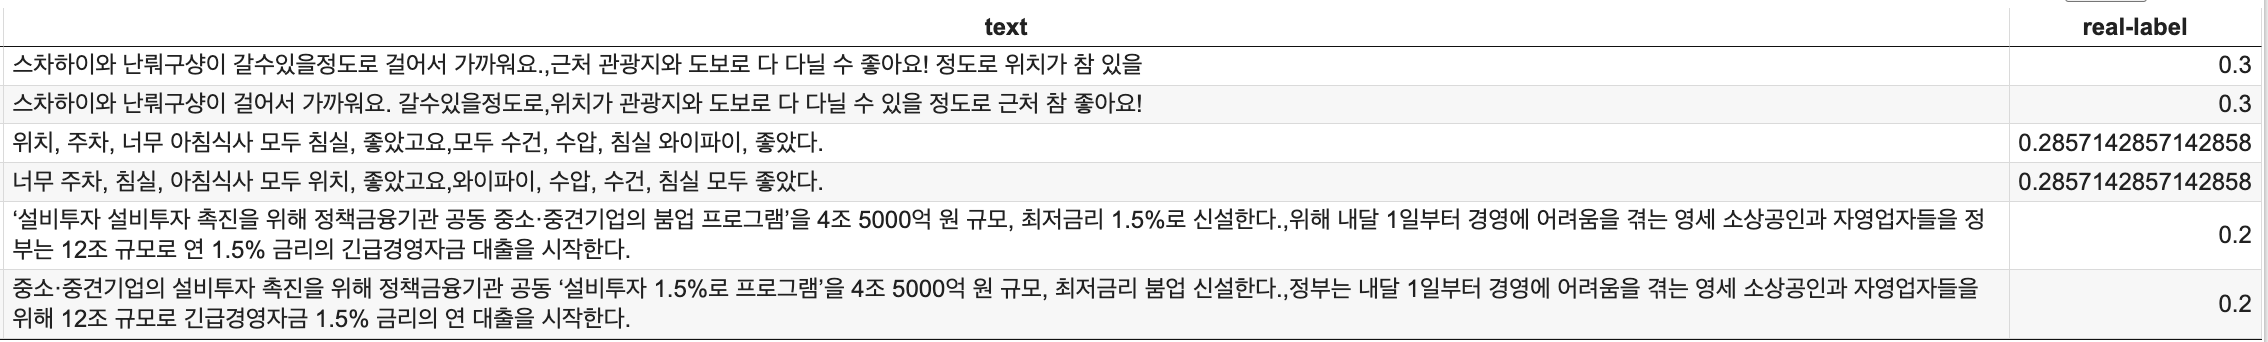

In [ ]:
import pickle
import re

In [ ]:
def random_swap(words, n):
  """ 랜덤 스와핑할 문장을 생성합니다 """
  new_words = words.copy()
  for _ in range(n):
  	new_words = swap_word(new_words)

  return new_words

def swap_word(new_words):
  """ 문장 내 두 단어의 위치를 n회 변경합니다 """
  random_idx_1 = random.randint(0, len(new_words)-1)
  random_idx_2 = random_idx_1
  counter = 0

  while random_idx_2 == random_idx_1:
  	random_idx_2 = random.randint(0, len(new_words)-1)
  	counter += 1
  	if counter > 3:
  		return new_words

  new_words[random_idx_1], new_words[random_idx_2] = new_words[random_idx_2], new_words[random_idx_1]
  return new_words

In [ ]:
def EDAforTextPair(text_pair, alpha=0.1, num_aug=4):
  """ Easy Data Augmentation for Text pair
  input : text_pair (list of string)
  ouput : augmented sentences (list of list)
  parameters : EDA 연구진의 제안을 따름; train 데이터 수가 5,000개 이상일 때 alpha=0.1, num_aug=4
  """
  augmented_text_pair = []
  for i in range(len(text_pair)):
    sentence = text_pair[i]
    words = sentence.split(' ')
    words = [word for word in words if word is not ""]
    num_words = len(words)

    augmented_sentences = []
    num_new_per_technique = int(num_aug/4) + 1

    n_rs = max(1, int(alpha*num_words))

    # Random Swap
    for _ in range(num_new_per_technique):
      a_words = random_swap(words, n_rs)
      augmented_sentences.append(" ".join(a_words))

    augmented_sentences = [sentence for sentence in augmented_sentences]
    random.shuffle(augmented_sentences)

    if num_aug >= 1:
      augmented_sentences = augmented_sentences[:num_aug]
    else:
      keep_prob = num_aug / len(augmented_sentences)
      augmented_sentences = [s for s in augmented_sentences if random.uniform(0, 1) < keep_prob]

    augmented_text_pair.append(augmented_sentences)

  return augmented_text_pair

In [ ]:
def ApplyEDAtoDataframe(df):
  """ 랜덤 스와핑 기법을 이용해 데이터프레임의 모든 데이터를 증강합니다 """

  new_dict = {'text':[], 'real-label':[]}
  for text_pair in df['text']:
    new_txt = EDAforTextPair(text_pair)
    sentence1, sentence2 = new_txt
    for i in range(len(sentence1)):
      t = [sentence1[i], sentence2[i]]
      new_dict['text'].append(t)

  for label in df['real-label']:
    new_dict['real-label'].append(label)
    new_dict['real-label'].append(label)   # 와 진짜 더럽다.. 이런 하드코딩 처음본다

  new_sample = pd.DataFrame.from_dict(new_dict)
  return new_sample